In [1]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import norm
import time
import pandas as pd

In [2]:
# Import your modules
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging/MA4288O-Project')

from market.heston import simulate_two_assets
from utils.networks import RecurrentHedgeModel
from utils.multi_networks import RecurrentHedgeModel5D
from optimizer.hedge_train_5d import train_5D_cvar, compute_5D_pnl
from optimizer.hedge_train import DeepHedgeCVaRTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 🧪 Simulate 2 correlated assets
num_paths = 10_000  # Reduced for stability
num_steps = 30
T = 30 / 365
dt = T / num_steps

S_np, V_np = simulate_two_assets(n_paths=num_paths, n_steps=num_steps, dt=dt)
print("Simulated shape:", S_np.shape)  # (paths, steps+1, 2)

# 💰 Payoff: European call on asset 1
K = 100
Z_np = np.maximum(S_np[:, -1, 0] - K, 0)

# Convert to torch
S_torch_1D = torch.from_numpy(S_np[:, :, 0:1]).float().to(device)
S_torch_2D = torch.from_numpy(S_np).float().to(device)
Z_torch = torch.from_numpy(Z_np).float().to(device)

Simulated shape: (10000, 31, 2)


In [ ]:
# 🧠 Train single-asset hedge (safe config)
num_steps = S_torch_1D.shape[1] - 1
model_1D = RecurrentHedgeModel(steps=num_steps, hidden_dim=16).to(device)  # ↓ hidden dim

trainer_1D = DeepHedgeCVaRTrainer(model=model_1D, alpha=0.5)
start = time.time()
q_1D = trainer_1D.train(
    S_tensor=S_torch_1D,
    Z_tensor=Z_torch,
    p0_init=2.0,
    n_epochs=5,
    batch_size=1024
)
with torch.no_grad():
    deltas_1D = model_1D(S_torch_1D)
    Sdiff = S_torch_1D[:, 1:] - S_torch_1D[:, :-1]
    gains = torch.sum(deltas_1D * Sdiff, dim=1)
    pnl_1D = (q_1D - Z_torch + gains).cpu().numpy()
end = time.time()
time_1D = end - start

Epoch 1/5 | Loss: 18.2325 | p0: 2.0000
Epoch 2/5 | Loss: 13.0672 | p0: 2.0000
Epoch 3/5 | Loss: 8.8957 | p0: 2.0000
Epoch 4/5 | Loss: 4.9691 | p0: 2.0000
Epoch 5/5 | Loss: 2.5762 | p0: 2.0000


In [5]:
from utils.multi_networks import RecurrentHedgeModel2D
from optimizer.hedge_train import cvar_loss_canonical

In [6]:
# 🧠 Train 2-asset hedge

model_2D = RecurrentHedgeModel2D(steps=num_steps, in_dim=4, hidden_dim=32, out_dim=2).to(device)

start = time.time()
q_2D = train_5D_cvar(
    model_2D,
    S_tensor=S_torch_2D,
    payoff_tensor=Z_torch,
    alpha=0.5,
    lr=1e-3,
    p0_init=q_1D,
    n_epochs=5,
    batch_size=4096
)
time_2D = time.time() - start

with torch.no_grad():
    deltas_2D = model_2D(S_torch_2D)
    pnl_2D = compute_5D_pnl(q_2D, Z_torch, deltas_2D, S_torch_2D).cpu().numpy()

In [7]:
# 📈 Compute and compare metrics
def empirical_cvar(pnl, alpha=0.5):
    pnl_sorted = np.sort(pnl)
    idx = int(len(pnl) * alpha)
    return np.mean(pnl_sorted[:idx])

results = {
    "Single-Asset Hedge": {
        "pnl": pnl_1D,
        "price": q_1D,
        "time": time_1D
    },
    "Two-Asset Hedge": {
        "pnl": pnl_2D,
        "price": q_2D,
        "time": time_2D
    }
}

for name, res in results.items():
    pnl = res["pnl"]
    res["mean"] = np.mean(pnl)
    res["std"] = np.std(pnl)
    res["mshe"] = np.mean(pnl**2)
    res["cvar"] = empirical_cvar(pnl, alpha=0.5)

summary_df = pd.DataFrame({
    name: {
        "Mean PnL": f"{res['mean']:.4f}",
        "Std PnL": f"{res['std']:.4f}",
        "MSHE": f"{res['mshe']:.4f}",
        "CVaR (0.5)": f"{res['cvar']:.4f}",
        "Price (q)": f"{res['price']:.4f}",
        "Time (s)": f"{res['time']:.2f}"
    }
    for name, res in results.items()
}).T

print("\n🔍 Multi-Asset Hedge Comparison:\n")
print(summary_df)


🔍 Multi-Asset Hedge Comparison:

                   Mean PnL  Std PnL       MSHE CVaR (0.5) Price (q) Time (s)
Single-Asset Hedge  -0.3011   3.0266     9.2511    -0.2988    2.0000    12.97
Two-Asset Hedge      0.0375  74.9112  5611.6890   -58.9197    2.0150     0.75


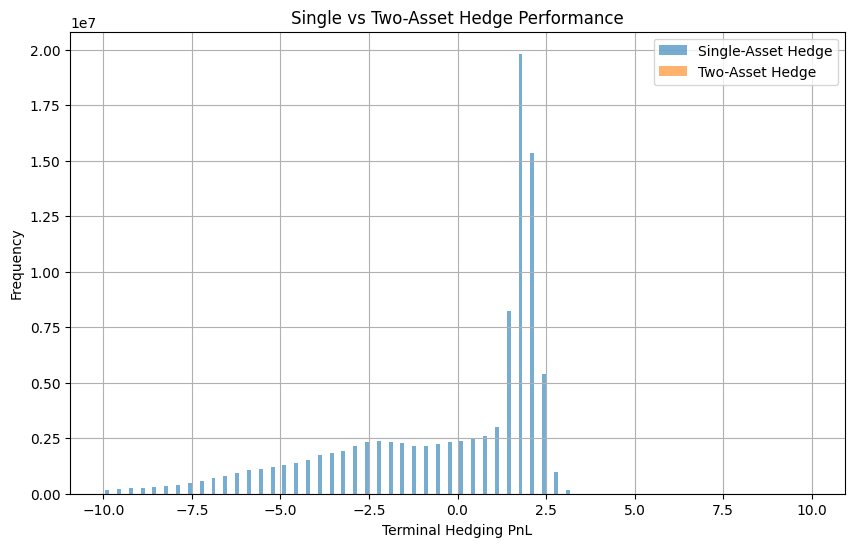

In [8]:
# 📊 PnL Histogram
def plot_hist(pnl1, pnl2, label1, label2, bins=60, x_range=(-10,10)):
    counts1, edges = np.histogram(pnl1, bins=bins, range=x_range)
    counts2, _     = np.histogram(pnl2, bins=edges)
    centers = 0.5 * (edges[:-1] + edges[1:])
    width = (edges[1] - edges[0]) / 3.0

    plt.figure(figsize=(10,6))
    plt.bar(centers - width/2, counts1, width=width, alpha=0.6, label=label1)
    plt.bar(centers + width/2, counts2, width=width, alpha=0.6, label=label2)
    plt.xlabel("Terminal Hedging PnL")
    plt.ylabel("Frequency")
    plt.title("Single vs Two-Asset Hedge Performance")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_hist(pnl_1D, pnl_2D, "Single-Asset Hedge", "Two-Asset Hedge")